# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_2m_1f_240216_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 54000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1547.276912,18.216714,1546.991450,18.173563,0.0,1514.000000,0.000000,0.556863,1518.000000,0.000000,1.480116,1412.0,100.420140,24.978034,0.968571,5
1,1,0,1403.907583,761.124502,1401.725777,760.805712,0.0,1310.000000,696.000000,0.631373,1460.000000,741.000000,1.210330,13807.0,271.968295,98.725123,0.931788,5
2,2,0,1126.879266,976.638145,1115.586179,966.631176,NaN,1126.879266,976.638145,NaN,1126.879266,976.638145,0.802365,14445.0,255.202600,95.577199,0.927221,5
3,3,0,779.056655,979.195277,782.122178,975.796889,0.0,775.000000,923.000000,0.611765,764.000000,1028.000000,-1.545258,11773.0,168.342601,131.012637,0.627955,5
4,4,0,949.242925,992.341981,946.508098,993.649536,NaN,949.242925,992.341981,NaN,949.242925,992.341981,-1.002535,424.0,135.294576,37.522772,0.960771,5
5,0,3,1545.709078,18.035076,1545.402620,17.998425,NaN,1545.709078,18.035076,NaN,1545.709078,18.035076,1.477379,1454.0,100.873748,26.858927,0.963900,6


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         5  1547.276912   18.216714     1.480116
1   1     0         5  1403.907583  761.124502     1.210330
2   2     0         5  1126.879266  976.638145     0.802365
3   3     0         5   779.056655  979.195277    -1.545258
4   4     0         5   949.242925  992.341981    -1.002535


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,1403.907583,761.124502,1401.725777,760.805712,0.0,1310.000000,696.000000,0.631373,1460.000000,741.000000,1.210330,13807.0,271.968295,98.725123,0.931788,5
2,1,0,1126.879266,976.638145,1115.586179,966.631176,NaN,1126.879266,976.638145,NaN,1126.879266,976.638145,-0.802365,14445.0,255.202600,95.577199,0.927221,5
3,2,0,779.056655,979.195277,782.122178,975.796889,0.0,775.000000,923.000000,0.611765,764.000000,1028.000000,1.545258,11773.0,168.342601,131.012637,0.627955,5
5,0,3,1545.709078,18.035076,1545.402620,17.998425,NaN,1545.709078,18.035076,NaN,1545.709078,18.035076,1.477379,1454.0,100.873748,26.858927,0.963900,6
6,1,3,1425.226439,777.070024,1422.449473,775.874207,0.0,1328.000000,706.000000,0.631373,1393.000000,745.000000,1.165194,15152.0,276.673115,98.918882,0.933902,6
7,2,3,1132.689255,971.136549,1124.310657,960.639846,NaN,1132.689255,971.136549,NaN,1132.689255,971.136549,0.767940,14742.0,256.162157,91.297650,0.934331,6
8,3,3,782.934290,980.764334,785.540982,976.850032,0.0,812.000000,924.000000,0.509804,796.000000,1012.000000,-1.534658,11703.0,169.351928,131.900836,0.627202,6


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
37424,3,53994,1390.781084,958.845051,1376.349222,947.865618,NaN,1390.781084,958.845051,NaN,1390.781084,958.845051,0.944462,18619.0,248.958117,121.843267,0.872052,4
37425,0,53997,58.458667,853.886902,58.356831,848.815317,0.0,19.000000,750.000000,0.501961,84.000000,798.000000,0.039172,6375.0,143.877583,68.893101,0.877907,4
37426,1,53997,55.606195,907.535398,57.585773,909.700121,NaN,55.606195,907.535398,NaN,55.606195,907.535398,0.678319,226.0,136.064139,85.563903,0.777527,4
37427,2,53997,1656.570212,920.422315,1654.537094,919.439456,0.0,1656.000000,867.000000,0.435294,1673.000000,883.000000,0.995867,5754.0,99.234803,86.743264,0.485708,4
37428,3,53997,1390.763544,958.781317,1376.198545,947.791220,0.0,1344.000000,875.000000,0.521569,1489.000000,1007.000000,0.946519,18680.0,249.014235,121.758268,0.872306,4


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


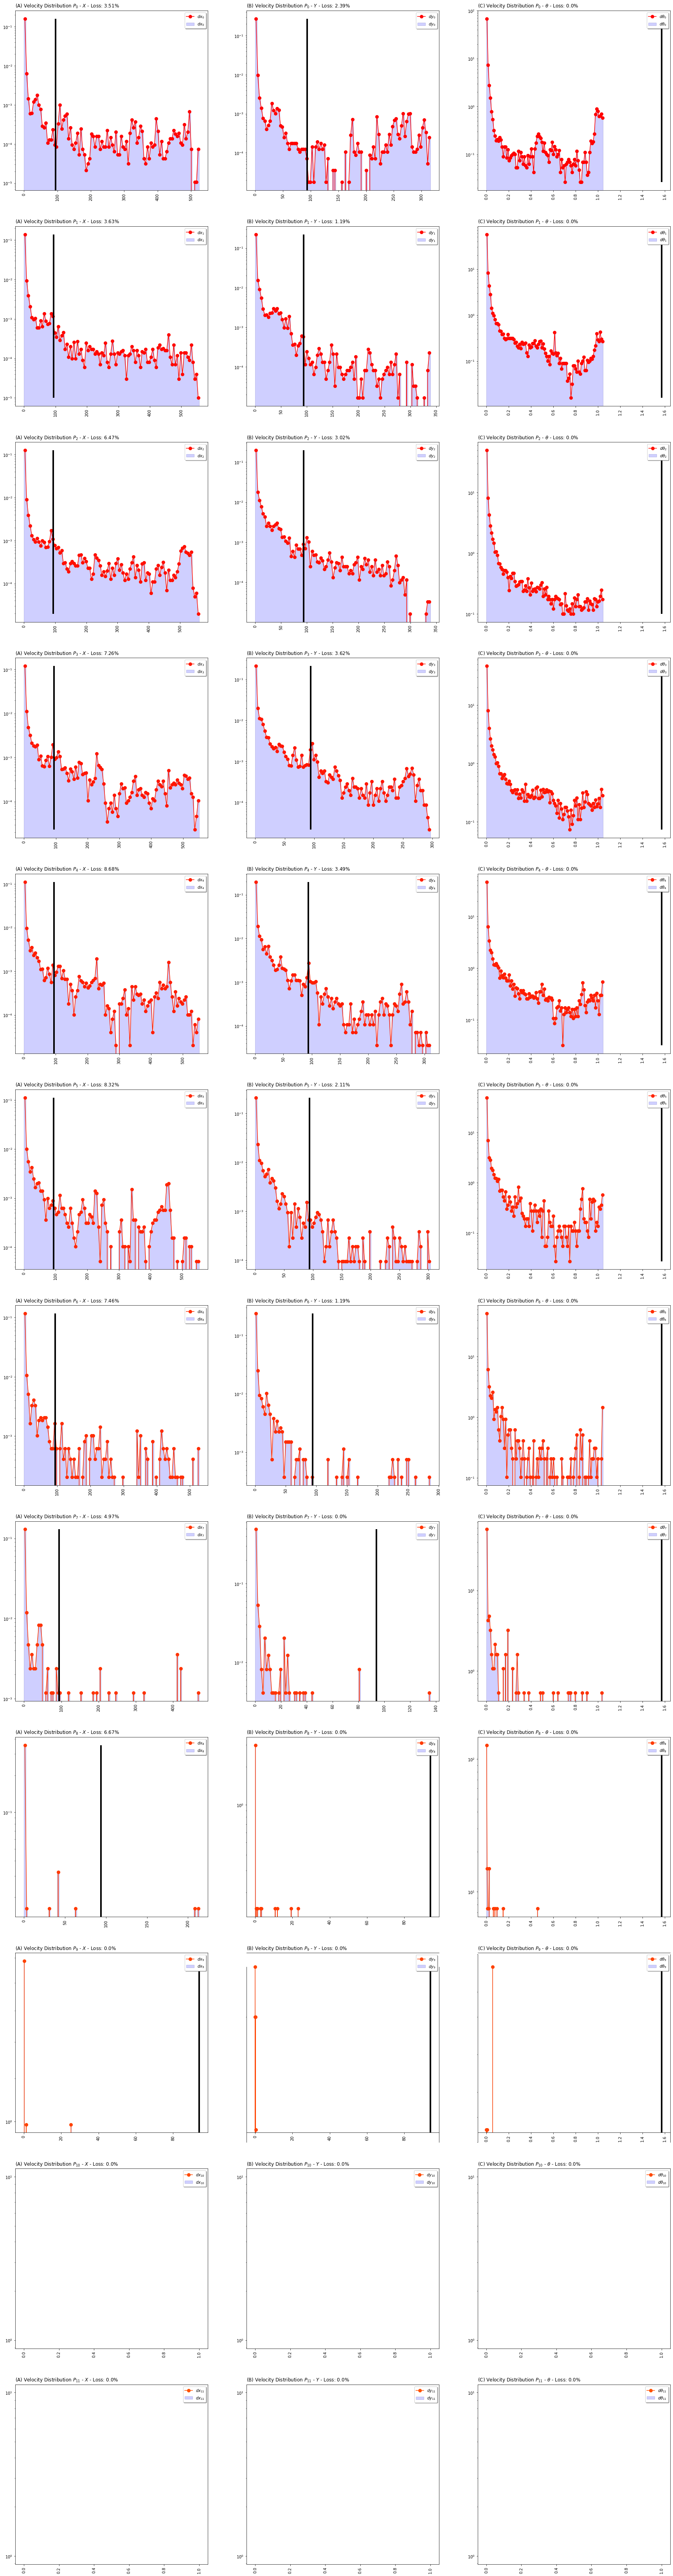

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,56
1,3,7161
2,4,26448
3,5,27558
4,6,15216
5,7,5208
6,8,1208
7,9,225
8,10,40
9,12,12


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 52.87782117333769 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.056537
1,2,False,True,False,0.009623
2,2,True,False,False,0.001203
3,3,False,False,False,7.776789
4,3,False,True,False,0.437858
5,3,True,False,False,0.280277
6,3,True,True,False,0.119088
7,4,False,False,False,29.731030
8,4,False,True,False,0.672425
9,4,True,False,False,1.159602


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 24.856332241455824 
	- Angle: 52.87782117333769 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 1.5186028853454823%
Final loss data Y-axis: 0.9982036039039206%
Final loss data Angle : 1.1556197566531474%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.022223
1,3,False,False,True,0.764857
2,3,False,True,False,0.033335
3,3,False,True,True,0.698187
4,3,True,False,True,0.211123
5,3,True,True,False,1.100061
6,3,True,True,True,97.170213


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 24.856332241455824 
	- Angle: 52.87782117333769 



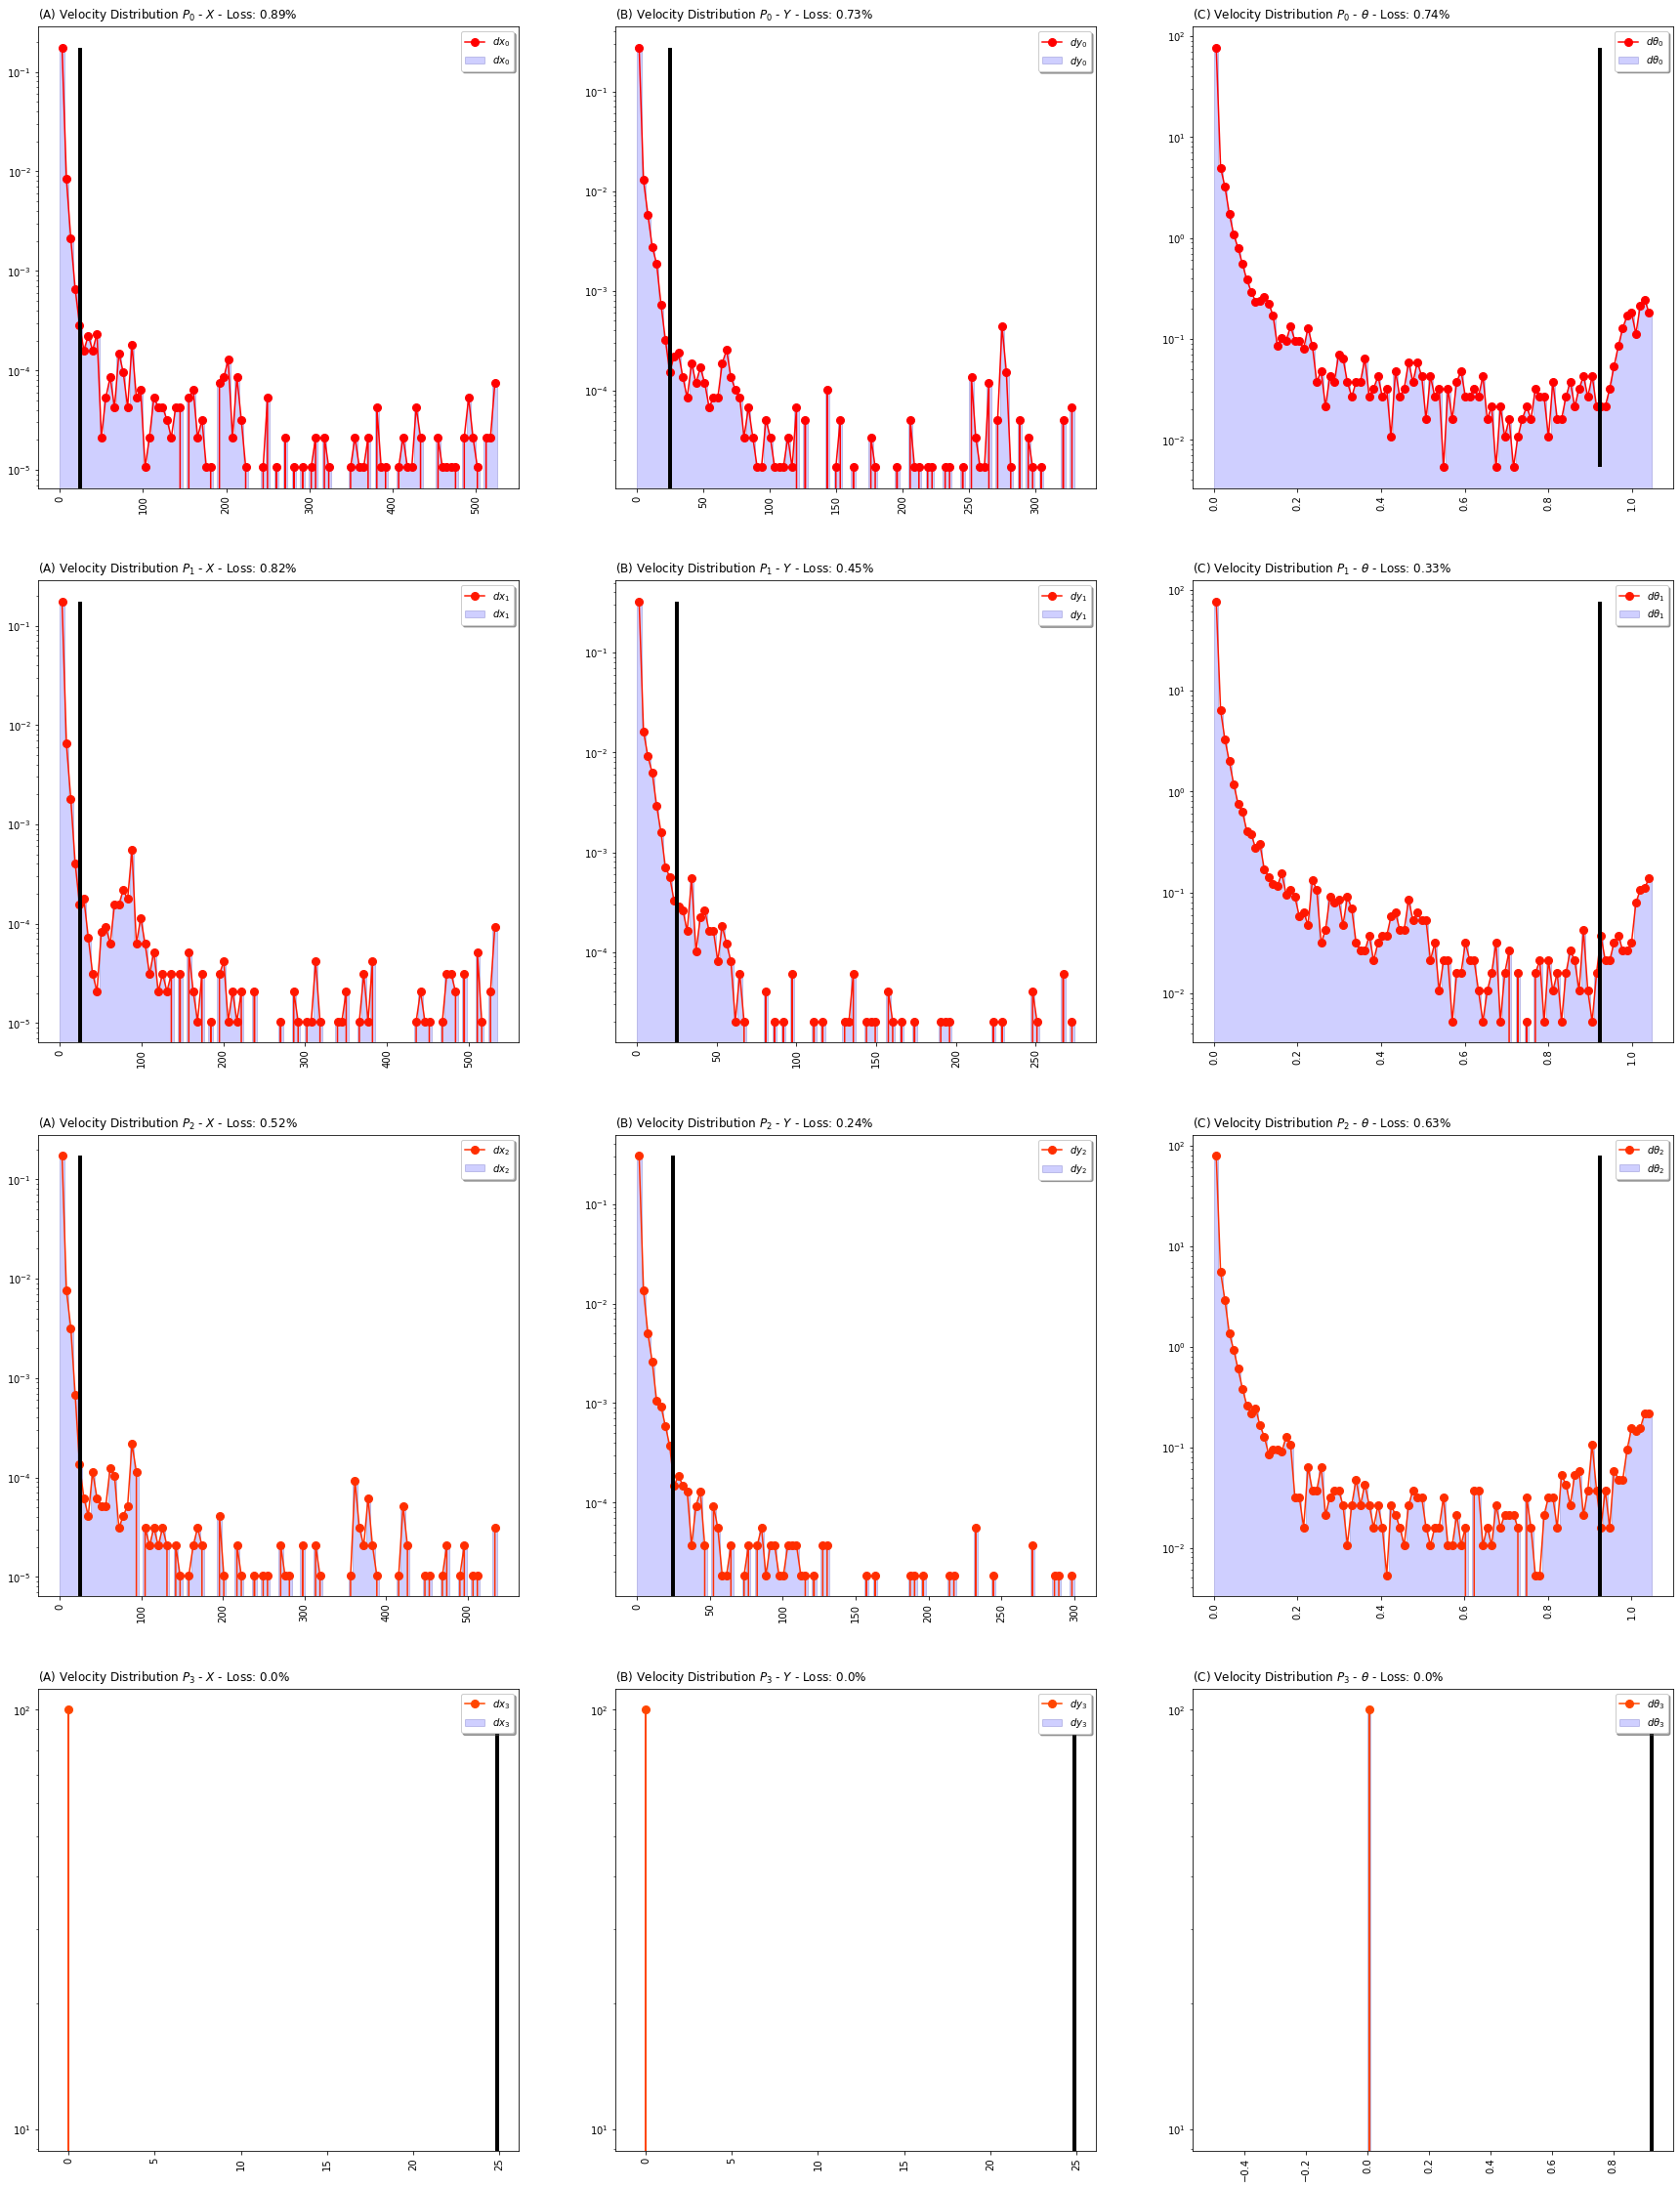

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1403.907583,761.124502,1401.725777,760.805712,0.0,1310.000000,696.000000,0.631373,1460.000000,741.000000,1.210330,13807.0,271.968295,98.725123,0.931788,3,NaN,NaN,NaN,NaN,False,False,False
2388,1,0,1126.879266,976.638145,1115.586179,966.631176,NaN,1126.879266,976.638145,NaN,1126.879266,976.638145,-0.802365,14445.0,255.202600,95.577199,0.927221,3,NaN,NaN,NaN,NaN,False,False,False
4776,2,0,779.056655,979.195277,782.122178,975.796889,0.0,775.000000,923.000000,0.611765,764.000000,1028.000000,1.545258,11773.0,168.342601,131.012637,0.627955,3,NaN,NaN,NaN,NaN,False,False,False
7164,0,3,1403.907583,761.124502,1401.725777,760.805712,0.0,1310.000000,696.000000,0.631373,1460.000000,741.000000,1.210330,13807.0,271.968295,98.725123,0.931788,3,3.0,0.000000,0.000000,0.0,False,False,False
7165,1,3,1129.784261,973.887347,1119.948418,963.635511,NaN,1129.784261,973.887347,NaN,1129.784261,973.887347,-0.802365,14445.0,255.202600,95.577199,0.927221,3,3.0,0.968332,-0.916933,0.0,False,False,False
7166,2,3,780.995473,979.979806,783.831580,976.323461,0.0,793.500000,923.500000,0.611765,780.000000,1020.000000,1.545258,11773.0,168.342601,131.012637,0.627955,3,3.0,0.646273,0.261509,0.0,False,False,False
7167,0,6,1430.800532,774.797330,1428.818219,774.322067,0.0,1339.500000,701.000000,0.631373,1428.500000,731.500000,1.210330,13807.0,271.968295,98.725123,0.931788,3,3.0,8.964316,4.557609,0.0,False,False,False
7168,1,6,1133.642451,968.712277,1123.874405,958.211335,NaN,1133.642451,968.712277,NaN,1133.642451,968.712277,-0.802365,14445.0,255.202600,95.577199,0.927221,3,3.0,1.286063,-1.725023,0.0,False,False,False
7169,2,6,780.995473,979.979806,783.831580,976.323461,0.0,793.500000,923.500000,0.611765,780.000000,1020.000000,1.545258,11773.0,168.342601,131.012637,0.627955,3,3.0,0.000000,0.000000,0.0,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_2m_1f_240216_1_c.zip'